In [1]:
%matplotlib inline
from numpy import *
import numpy as np
import math
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import matplotlib.cm as cm 

from astropy.io import fits
from astropy.nddata import CCDData
from astropy.stats import mad_std, SigmaClip, sigma_clipped_stats
from photutils.detection import DAOStarFinder
from platform import python_version
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import *
from astropy.visualization import SqrtStretch
from photutils import *
from astropy.modeling.models import Moffat1D
from scipy.signal import peak_widths
from scipy.ndimage import gaussian_filter
from astropy.visualization import simple_norm, ImageNormalize, ZScaleInterval



import pandas as pd
from astropy.table import Table
from astropy import units as u

import sys

sys.path.insert(0, '/Users/josue/kosmos/')
import warnings
warnings.filterwarnings('ignore')


In [2]:
import kosmos
DISPLAY = True

In [3]:
kosmos.__version__

'0.1'

In [4]:
#checks the filter
def what_filter(k):
    j = []
    for i in k:
        hdu_list = fits.open(i)
        a = hdu_list[0].header['FILTER']
        j.append(a)
    print("Filters:")
    return j

# Creats a directory array
def dir_array(j):
    i = pd.read_table(dir + j, names=['impath'])
    k = dir + i['impath'].values
    #print(k)
    return k

## 1. Master Bias

In [5]:
dir = 'C:/Users/josue/Work-space/data/07082022/'
dir_2 = 'C:/Users/josue/Work-space/data/07102022/'
dir_3 = 'C:/Users/josue/Work-space/data/07072022/07072022/'
biasfiles_i = pd.read_table(dir + 'bias_08.txt', names=['impath'])
biasfiles = dir + biasfiles_i['impath'].values
print(biasfiles)

biasfiles_i_1 = pd.read_table(dir_3 + 'bias_07.txt', names=['impath'])
biasfiles_1 = dir_3 + biasfiles_i_1['impath'].values
print(biasfiles_1)

['C:/Users/josue/Work-space/data/07082022/bias_001.fits'
 'C:/Users/josue/Work-space/data/07082022/bias_002.fits'
 'C:/Users/josue/Work-space/data/07082022/bias_003.fits'
 'C:/Users/josue/Work-space/data/07082022/bias_004.fits'
 'C:/Users/josue/Work-space/data/07082022/bias_005.fits'
 'C:/Users/josue/Work-space/data/07082022/bias_006.fits'
 'C:/Users/josue/Work-space/data/07082022/bias_007.fits']
['C:/Users/josue/Work-space/data/07072022/07072022/bias_01.fits'
 'C:/Users/josue/Work-space/data/07072022/07072022/bias_02_001.fits'
 'C:/Users/josue/Work-space/data/07072022/07072022/bias_02_002.fits']


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(512, 512)


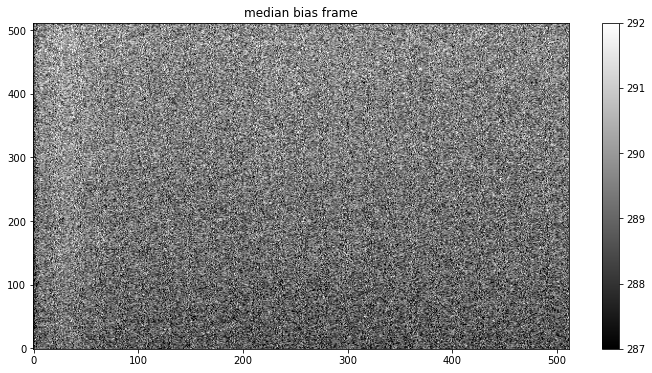

In [6]:
bias = kosmos.biascombine(biasfiles) 
print(bias.shape)

# if DISPLAY:
#     plt.figure(figsize=(12,6))
#     plt.imshow(bias, origin='lower', aspect='auto', cmap=plt.cm.gray)
#     plt.title('median bias frame')
#     plt.clim(np.percentile(bias, (5, 98)))
#     cb = plt.colorbar()

Image minimum =  274
Image maximum =  302
Image mean =  288.75390625
Image standard deviation =  2.5559176128643113


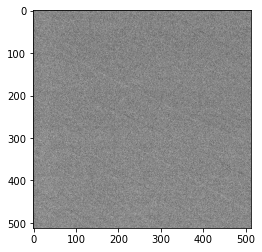

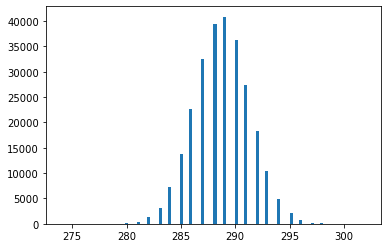

Selecting pixel values between  0.0  and  65000.0
Image minimum =  274
Image maximum =  302
Image mean =  288.75390625
Image standard deviation =  2.5559176128643113


In [7]:
h = pyfits.open('C:/Users/josue/Work-space/data/07082022/bias_005.fits')

img = h[0].data

plt.ion()   
colmap = plt.get_cmap('gray') 

plt.figure(1)
plt.clf()
plt.imshow(img, cmap=colmap) 
nx, ny = img.shape 
imgh = reshape(img, nx*ny) 
#print(img)
# print some statistics about the image
print ('Image minimum = ', min(imgh))
print ('Image maximum = ', max(imgh))
print ('Image mean = ', mean(imgh))
print ('Image standard deviation = ', std(imgh))

plt.figure(2)
plt.clf()
plt.hist(imgh, bins=100)
plt.show()

plow = 0.0
phi = 65000.0
print ('Selecting pixel values between ', plow, ' and ', phi)
q = where((imgh >= plow) & (imgh <= phi))
imghcut = imgh[q]

print ('Image minimum = ', min(imghcut))
print ('Image maximum = ', max(imghcut))
print ('Image mean = ', mean(imghcut))
print ('Image standard deviation = ', std(imghcut))

## 2. Master Flats (compareing dome flats to sky flats)

In [8]:
# dome flats
dome_flats_B = dir_array('dome_flats_B.txt')
dome_flats_r = dir_array('dome_flats_r.txt')
dome_flats_V = dir_array('dome_flats_V.txt')
# sky flats
sky_flats_B = dir_array('sky_flats_B.txt')
sky_flats_r = dir_array('sky_flats_r.txt')
sky_flats_V = dir_array('sky_flats_V.txt')
flats_r_15s = dir_array('Flat_r_15s.txt')
# confirming filter
#what_filter(dome_flats_B)
what_filter(biasfiles)

Filters:


['B', 'B', 'B', 'B', 'B', 'B', 'B']

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(512,)
(512, 512)
adu / s
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passe

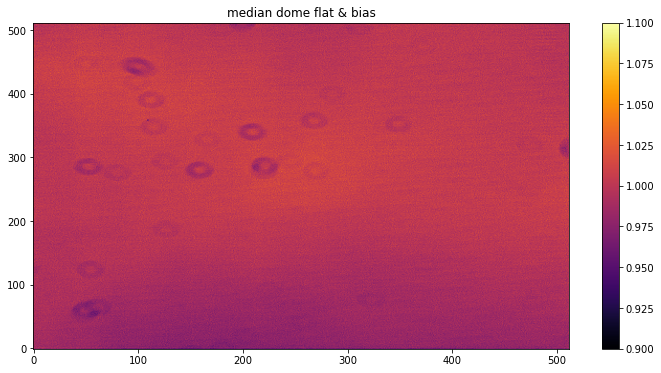

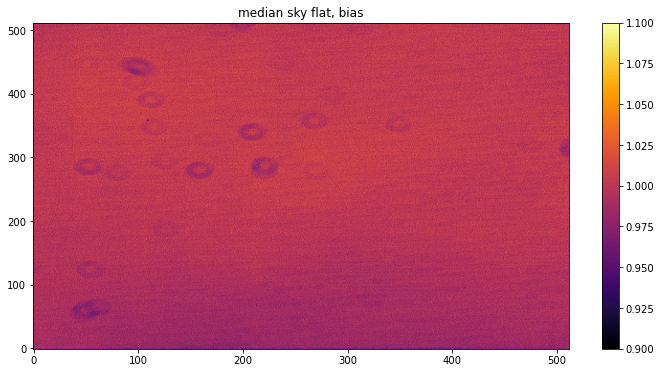

In [9]:
# B filter dome master flat
flat_B, ilum_B = kosmos.flatcombine(dome_flats_B, bias=bias, trim=None)

print(ilum_B.shape) # this is the indicies that are illuminated
print(flat_B.shape)
print(flat_B.unit)

if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.imshow(flat_B, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(.9,1.1)
    plt.title('median dome flat & bias')
    cb = plt.colorbar()

# B filter sky master flat
sky_flat_B, sky_ilum_B = kosmos.flatcombine(sky_flats_B, bias=bias, trim=None)

print(sky_ilum_B.shape) # this is the indicies that are illuminated
print(sky_flat_B.shape)
print(sky_flat_B.unit)

if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.imshow(sky_flat_B, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(.9,1.1)
    plt.title('median sky flat, bias')
    cb = plt.colorbar()

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(512,)
(512, 512)
adu / s
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passe

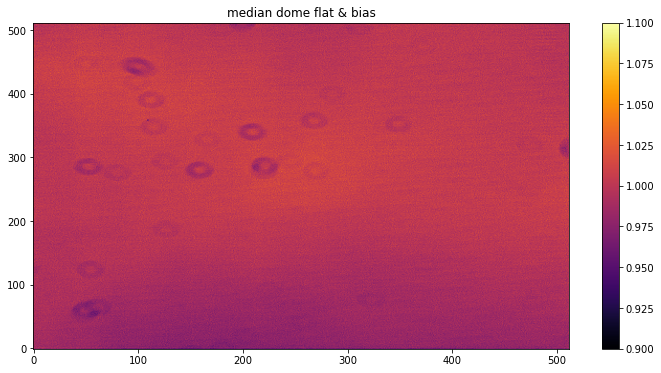

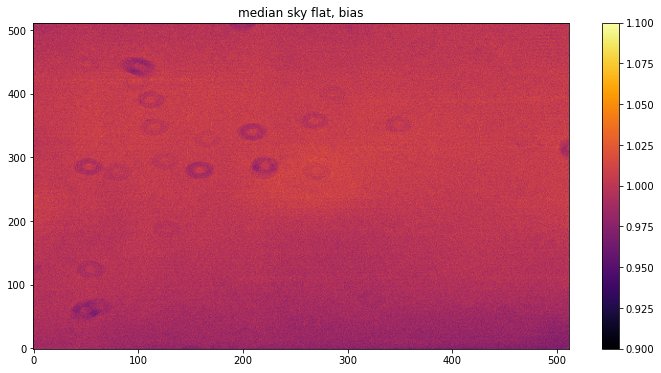

In [10]:
# r filter dome master flat
flat_r, ilum_r = kosmos.flatcombine(dome_flats_r, bias=bias, trim=None)

print(ilum_r.shape) # this is the indicies that are illuminated
print(flat_r.shape)
print(flat_r.unit)

if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.imshow(flat_B, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(.9,1.1)
    plt.title('median dome flat & bias')
    cb = plt.colorbar()

# r filter sky master flat
sky_flat_r, sky_ilum_r = kosmos.flatcombine(sky_flats_r, bias=bias, trim=None)

print(sky_ilum_r.shape) # this is the indicies that are illuminated
print(sky_flat_r.shape)
print(sky_flat_r.unit)

if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.imshow(sky_flat_r, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(.9,1.1)
    plt.title('median sky flat, bias')
    cb = plt.colorbar()

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(512,)
(512, 512)
adu / s
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passe

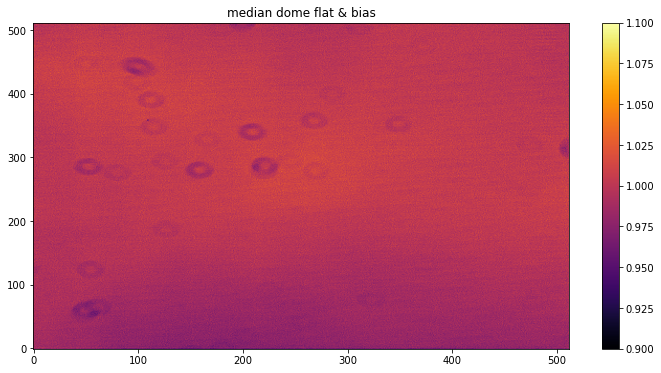

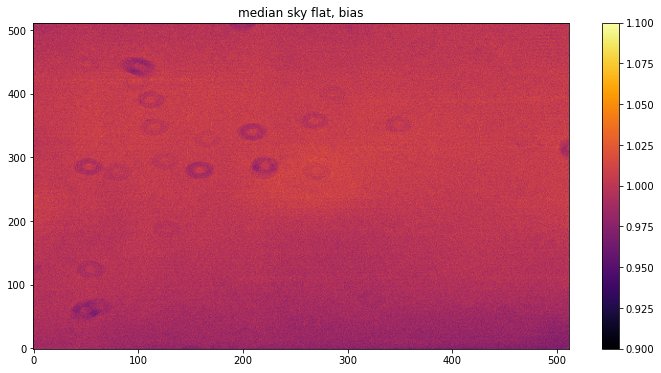

In [11]:
# V filter dome master flat
flat_V, ilum_V = kosmos.flatcombine(dome_flats_r, bias=bias, trim=None)

print(ilum_V.shape) # this is the indicies that are illuminated
print(flat_V.shape)
print(flat_V.unit)

if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.imshow(flat_B, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(.9,1.1)
    plt.title('median dome flat & bias')
    cb = plt.colorbar()

# V filter sky master flat
sky_flat_V, sky_ilum_V = kosmos.flatcombine(sky_flats_r, bias=bias, trim=None)

print(sky_ilum_V.shape) # this is the indicies that are illuminated
print(sky_flat_V.shape)
print(sky_flat_V.unit)

if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.imshow(sky_flat_V, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(.9,1.1)
    plt.title('median sky flat, bias')
    cb = plt.colorbar()

In [12]:
sky_flat_V

CCDData([[0.95101213, 0.95535432, 0.9442807 , ..., 0.92790037, 0.95240466,
          0.92039308],
         [1.05812506, 1.05754999, 1.05862877, ..., 1.0430154 , 1.04327981,
          1.04951063],
         [0.95613598, 0.96744955, 0.96529165, ..., 0.9442957 , 0.95308052,
          0.95020283],
         ...,
         [0.99268609, 0.98370332, 0.99212685, ..., 0.9920344 , 1.00143947,
          1.00471125],
         [0.99891825, 0.9900144 , 0.99560963, ..., 1.00019633, 0.98476397,
          0.98690081],
         [0.98337324, 0.9896412 , 0.99037799, ..., 1.00186529, 0.99950484,
          1.00774227]], unit='adu / s')

In [13]:
flat_V

CCDData([[0.94187205, 0.94132152, 0.9349877 , ..., 0.91927094, 0.92882778,
          0.91229295],
         [1.07272173, 1.06776327, 1.0652856 , ..., 1.06408337, 1.05735629,
          1.06675472],
         [0.95897017, 0.96253429, 0.95591967, ..., 0.95270558, 0.96033002,
          0.95776376],
         ...,
         [0.99136709, 0.99236122, 0.99048281, ..., 0.99638415, 1.00653271,
          0.99721083],
         [0.99524413, 0.99717701, 0.99558535, ..., 0.99618899, 0.99246698,
          0.97803683],
         [0.98882597, 0.99330961, 0.99351037, ..., 0.99617225, 0.9958068 ,
          0.995625  ]], unit='adu / s')

In [14]:
n = sky_flat_V.data
b = flat_V.data

In [15]:
g = n/b
the_ultimate_flat = CCDData(g, unit="adu / s")

In [16]:
the_ultimate_flat

CCDData([[1.00970417, 1.01490755, 1.00993917, ..., 1.00938725, 1.02538348,
          1.00887887],
         [0.98639287, 0.99043489, 0.99375113, ..., 0.98020083, 0.9866871 ,
          0.983835  ],
         [0.99704455, 1.00510658, 1.00980415, ..., 0.99117263, 0.99245103,
          0.99210564],
         ...,
         [1.00133048, 0.99127546, 1.00165984, ..., 0.99563447, 0.99493981,
          1.0075214 ],
         [1.00369168, 0.99281711, 1.00002439, ..., 1.00402267, 0.99223852,
          1.00906304],
         [0.99448566, 0.99630688, 0.99684716, ..., 1.00571491, 1.00371361,
          1.01217051]], unit='adu / s')

<built-in method mean of numpy.ndarray object at 0x0000014C8B328210>


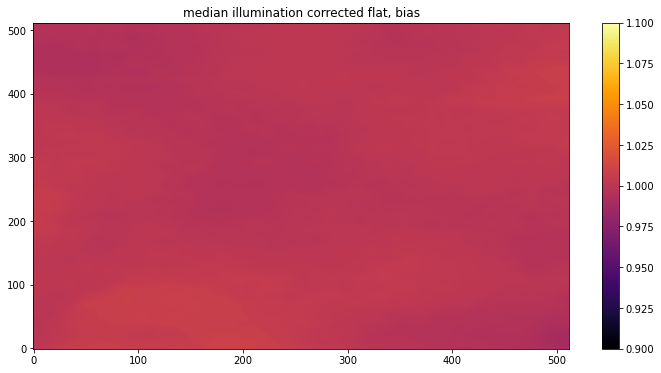

In [17]:
if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.imshow(gaussian_filter(the_ultimate_flat, sigma = 5),origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(.9,1.1)
    plt.title('median illumination corrected flat, bias')
    cb = plt.colorbar()
filter_mean = gaussian_filter(the_ultimate_flat, sigma = 5)
print(filter_mean.mean)

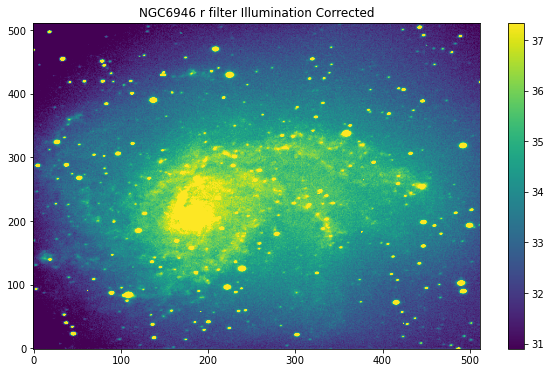

In [18]:
# NGC 6229 in the r filter
scii = dir_2 + 'ngc6946_r.fits'
sciiimg = kosmos.proc(scii, bias=bias, ilum=None, flat=gaussian_filter(the_ultimate_flat, sigma = 5), trim=None)

if DISPLAY:
    plt.figure(figsize=(10,6))
    plt.imshow(sciiimg, origin='lower', aspect='auto')
    #plt.imshow(flat_V, origin='lower', aspect='auto')
    plt.clim(np.percentile(sciiimg, (5, 98)))
    cb = plt.colorbar()
    plt.title('NGC6946 r filter Illumination Corrected')

In [19]:
good = dir_2 + 'PG1648_B_005.fits'
imgsci = CCDData.read(good, unit=u.adu)
imgsci

CCDData([[2054, 2066, 2034, ..., 2079, 2136, 2078],
         [2289, 2235, 2215, ..., 2266, 2253, 2259],
         [2106, 2103, 2118, ..., 2062, 2193, 2016],
         ...,
         [1943, 1993, 2153, ..., 2056, 2094, 2038],
         [2025, 1988, 2051, ..., 2093, 2101, 2067],
         [2006, 1946, 1990, ..., 2023, 2090, 2013]], unit='adu')

(512, 512)
adu / s


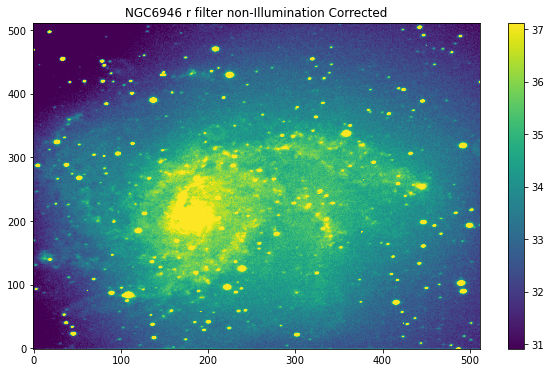

In [20]:

sci = dir_2 + 'ngc6946_r.fits'
sciimg_1 = kosmos.proc(sci, bias=bias, ilum=None, flat=flat_B, trim=None)

print(sciimg_1.shape)
print(sciimg_1.unit)

if DISPLAY:
    plt.figure(figsize=(10,6))
    plt.imshow(sciimg_1, origin='lower', aspect='auto')
    plt.clim(np.percentile(sciimg_1, (5, 98)))
    cb = plt.colorbar()
    plt.title('NGC6946 r filter non-Illumination Corrected')

In [21]:
img_1 = np.mean(sciiimg)
img_1

33.579736465482355

In [22]:
img_2 = np.mean(sciimg_1)
img_2

33.63907772651425

#### When looking at the illumination correction sciimg and comparing it to the non illumination correction sciimag we see a small change in the mean value. the illumination corrected image has a difference of 0.02. From this we can conclude that the illumination correced image has no significant impact.

In [23]:
flats_r_15s = dir_array('Flat_r_15s.txt')

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(512,)
(512, 512)
adu / s


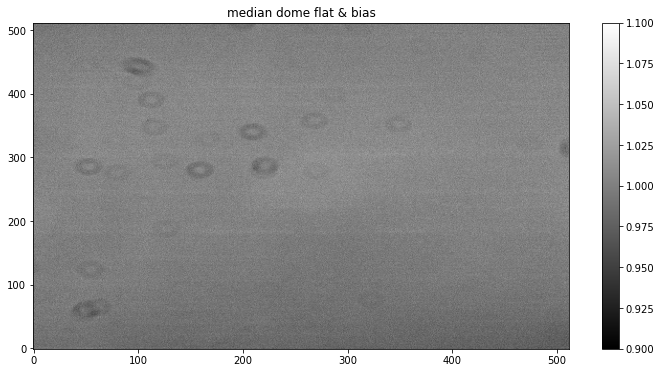

In [24]:
flat_B_1, ilum_B_1 = kosmos.flatcombine(flats_r_15s, bias=bias, trim=None)

print(ilum_B_1.shape) # this is the indicies that are illuminated
print(flat_B_1.shape)
print(flat_B_1.unit)

if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.imshow(flat_B_1, origin='lower', aspect='auto', cmap='gray')
    plt.clim(.9,1.1)
    plt.title('median dome flat & bias')
    cb = plt.colorbar()

# Lin Test

In [25]:
lin_test_flats = dir_array('linTest.txt')
lin_test_flats

array(['C:/Users/josue/Work-space/data/07082022/lintest_B_0_01.fits',
       'C:/Users/josue/Work-space/data/07082022/lintest_B_1.fits',
       'C:/Users/josue/Work-space/data/07082022/lintest_B_0_3.fits',
       'C:/Users/josue/Work-space/data/07082022/lintest_B_0_6.fits',
       'C:/Users/josue/Work-space/data/07082022/lintest_B_0_9.fits',
       'C:/Users/josue/Work-space/data/07082022/lintest_B_0.01.fits',
       'C:/Users/josue/Work-space/data/07082022/lintest_B_1_2.fits',
       'C:/Users/josue/Work-space/data/07082022/lintest_B_1_5.fits',
       'C:/Users/josue/Work-space/data/07082022/lintest_B_1_8.fits',
       'C:/Users/josue/Work-space/data/07082022/lintest_B_1.fits',
       'C:/Users/josue/Work-space/data/07082022/lintest_B_2_1.fits',
       'C:/Users/josue/Work-space/data/07082022/lintest_B_2_3.fits',
       'C:/Users/josue/Work-space/data/07082022/lintest_B_2_6.fits',
       'C:/Users/josue/Work-space/data/07082022/lintest_B_2_9.fits',
       'C:/Users/josue/Work-space/da

In [26]:
# takes the exposure time from the header and puts them in to an array
# then takes the mean count of all flats and put them in an array as well
exp_time = []
mean_count = []
for i in lin_test_flats:
    hdu_list = fits.open(i)
    k = hdu_list[0].data
    a = hdu_list[0].header['exptime']
    exp_time.append(a)
    mean = np.mean(k)
    mean_count.append(mean)

In [27]:
print(mean_count)
print(exp_time)

[870.6031188964844, 13381.484966278076, 4543.820972442627, 8485.049980163574, 12488.060291290283, 858.6680946350098, 16028.71375656128, 20187.79217147827, 24003.79121017456, 13381.484966278076, 27917.289489746094, 30736.766025543213, 33967.13705825806, 38573.34507751465, 42493.236015319824, 46440.70460128784, 50175.01345062256, 39320.00338745117, 55371.88290023804, 59930.374462127686, 60463.05109024048, 53190.1549949646, 53190.1549949646]
[0.01, 1.0, 0.3, 0.6, 0.9, 0.01, 1.2, 1.5, 1.8, 1.0, 2.1, 2.3, 2.6, 2.9, 3.2, 3.5, 3.8, 3.0, 4.2, 4.5, 4.8, 4.0, 4.0]


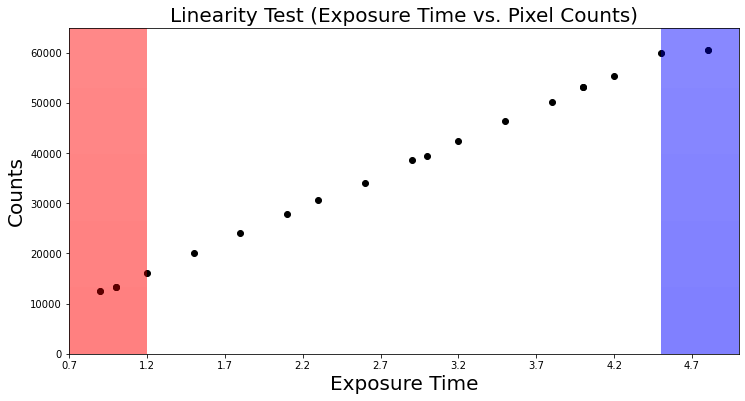

In [28]:
y = np.linspace(-5, 650000)
x = np.linspace(-0.5,1.2)
x_2 = np.linspace(4.5,4.5)
if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.scatter(exp_time, mean_count, c = 'k')
    plt.title('Linearity Test (Exposure Time vs. Pixel Counts)', fontsize = 20)
    plt.bar(-1, y, width = 2.2, color = 'r', alpha = 0.01, align = 'edge', label = 'Min Count')
    plt.bar(5, y, width = -0.5, color = 'b', alpha=0.01, align = 'edge', label = 'Max Count')
    plt.xlim(0.7, 5)
    plt.ylim(0, 65000)
    plt.xlabel("Exposure Time", fontsize = 20)
    plt.xticks(np.arange(0.7, 5, 0.5))
    plt.ylabel("Counts", fontsize = 20)
    #plt.legend(loc = 'upper left')
    

#### talk about what I saw visually and explain how that is reflected off in the graph

### Evora CCD Characterization

In [29]:
# gain = ((F_1 + F_2) - (B_1 + B_2)) / sig(F1-F2)**2 - sig(B1-B2)
print(dome_flats_B)
print(dome_flats_V)

['C:/Users/josue/Work-space/data/07082022/domeflat_1sec_3_001.fits'
 'C:/Users/josue/Work-space/data/07082022/domeflat_1sec_3_002.fits'
 'C:/Users/josue/Work-space/data/07082022/domeflat_1sec_3_003.fits'
 'C:/Users/josue/Work-space/data/07082022/domeflat_1sec_3_004.fits'
 'C:/Users/josue/Work-space/data/07082022/domeflat_1sec_3_005.fits']
['C:/Users/josue/Work-space/data/07082022/domeflat_1sec_V_001.fits'
 'C:/Users/josue/Work-space/data/07082022/domeflat_1sec_V_002.fits'
 'C:/Users/josue/Work-space/data/07082022/domeflat_1sec_V_003.fits'
 'C:/Users/josue/Work-space/data/07082022/domeflat_1sec_V_004.fits'
 'C:/Users/josue/Work-space/data/07082022/domeflat_1sec_V_005.fits'
 'C:/Users/josue/Work-space/data/07082022/domeflat_1sec_V_006.fits'
 'C:/Users/josue/Work-space/data/07082022/domeflat_1sec_V_007.fits']


In [30]:
# B filter flats
flat_1 = sky_flats_V[0]
flat_2 = dome_flats_V[1]

# B bias 
bias_1 = biasfiles[1]
bias_2 = biasfiles_1[1]

In [31]:
def get_data(i):
    hdu_list = fits.open(i)
    k = hdu_list[0].data
    return k

In [32]:
flat_1_data = get_data(flat_1)
flat_2_data = get_data(flat_2)

In [33]:
bias_2_data = get_data(bias_1)
bias_1_data = get_data(bias_2)
np.mean(bias_2_data)

289.603328704834

In [34]:
# mean for Flats and Bias
mean_f1 = np.mean(flat_1_data)
#print(mean_f1)
mean_f2 =  np.mean(flat_2_data)
#print(mean_f2)
mean_b1 = np.mean(bias_1_data)
#print(mean_b1)
mean_b2 = np.mean(bias_2_data)
#
print(mean_b2)

# stadndared deviation value for falts and bias
std_f1f2 = np.std(flat_1_data - flat_2_data)
print(std_f1f2)
std_b1b2 = np.std(bias_1_data - bias_2_data)

# not sure why this is so big
# mostlikly the error in the calculation
print(std_b1b2)


gainn = ((mean_f1+mean_f2)-(mean_b1+mean_b2))/(std_f1f2**2+std_b1b2**2)
print(gainn)
print(f'Gain is {gainn:.3f} e-/ADU')

# read noise
read_noise = gain*std_b1b2/np.sqrt(2)


print(f'Read noise is {read_noise:.3f} e-')
print(read_noise)

289.603328704834
419.2074245877524
31829.090028652274
6.892085989318943e-05
Gain is 0.000 e-/ADU


NameError: name 'gain' is not defined

## Extinction

In [ ]:
# BD+234616 in the B filter
sci = dir + 'lilsaldalbary_B_005.fits' 
sciimg_1 = kosmos.proc(sci, bias=bias, ilum=None, flat=flat_B, trim=None)

print(sciimg_1.shape)
print(sciimg_1.unit)

if DISPLAY:
    plt.figure(figsize=(15,12))
    plt.imshow(sciimg_1, origin='lower', aspect='auto')
    plt.clim(np.percentile(sciimg_1, (5, 99.5)))
    cb = plt.colorbar()
    plt.title(sci)

## Signal to Noise Ratio

In [ ]:
# Plot a 1-D model PSF
flux = 1
gamma = 1.09 # *Half* width at half max
alpha = 1  # power index (shape)
PSF = Moffat1D(flux, 0, gamma, alpha)
plt.figure(figsize=(16,6)) # make the plot w i d e
ymin, ymax = plt.ylim(-0.4,1.05) # make some space for labels
X = np.linspace(-25,25,250)
plt.plot(X, PSF(X))

# Label the fwhm
fwhm = PSF.fwhm
FWHM = 2.18
print("FWHM =", fwhm)
plt.hlines(0.5, 0-fwhm/2., 0+fwhm/2, color="k")
txt = plt.annotate("fwhm", (0, 0.4), size=15, ha="center")

# Show where a circular aperture would go
aperture_radius = 5
plt.hlines(-0.1, -aperture_radius, aperture_radius)
txt = plt.annotate("aperture", (0, -0.2), size=15, ha="center")

# Show sky annulus where background light is measured
annulus_r_in = -20
annulus_r_out = -23
plt.hlines(-0.1, -annulus_r_in, -annulus_r_out)
txt = plt.annotate("sky", (-annulus_r_out, -0.2), size=15)
plt.hlines(-0.1, annulus_r_in, annulus_r_out)
txt = plt.annotate("sky", (annulus_r_in, -0.2), size=15)

In [38]:
mean, median, std = sigma_clipped_stats(sciimg_1, sigma=3.0)

In [39]:
kill_me = sciimg_1.data
sciimg_1_data = np.ma.getdata(kill_me)

In [40]:
dao = DAOStarFinder(fwhm=2.18, threshold=117.*std)
sour = dao(sciimg_1_data - median)

In [41]:
print(sour)

None


In [42]:
dao = DAOStarFinder(fwhm=2.18, threshold=117.*std)
sources = dao(sciimg_1_data - median)
print(sources)
positions = []
for i, j in zip(sources['xcentroid'], sources['ycentroid']):
        positions.append((i,j));
apertures = CircularAperture(positions, r=5)
apertures_1 = CircularAperture(positions, r=1)
apertures_2 = CircularAperture(positions, r=9)
norm = ImageNormalize(stretch=SqrtStretch())
# if DISPLAY:
#     plt.figure(figsize=(20,20))
#     plt.imshow(sciimg_1_data, cmap='inferno', origin='lower', norm=norm)
#     apertures.plot(color='blue', lw=1.5, alpha=1);

None


TypeError: 'NoneType' object is not subscriptable

In [43]:
phot = aperture_photometry(sciimg_1, apertures)

for col in phot.colnames:phot[col].info.format = '%.8g'
source = phot['aperture_sum']
print(phot)

NameError: name 'apertures' is not defined

In [ ]:
annulus = CircularAnnulus(positions,r_in = 21.8,r_out = 30.52)
plt.figure(figsize=(24,24))
annulus.plot(color='deeppink',linewidth=2)
apertures_1.plot(color='k',linewidth=2, label = 'Smallest')
apertures_2.plot(color='b',linewidth=2, label = 'Biggest')
apertures.plot(color='lime',linewidth=2, label = 'Best')
plt.imshow(sciimg_1,norm=norm,cmap='pink');
total_sky = aperture_photometry(sciimg_1,annulus)['aperture_sum']
avg_sky = total_sky / annulus.area
sky = avg_sky * apertures.area
fluxes = source - sky
fluxes[0]
plt.legend(prop={'size': 30})

In [ ]:
extco = dir_array('extco.txt')

y = []
for i in extco:
    hdu_list = fits.open(i)
    a = hdu_list[0].header['airmass']
    y.append(a)


In [ ]:
extco_V = dir_array('extco_V.txt')

airmass_V = []
for i in extco_V:
    hdu_list = fits.open(i)
    a = hdu_list[0].header['airmass']
    airmass_V.append(a)

In [ ]:
def flux(path, thershold):
    sciimg_1 = kosmos.proc(path, bias=bias, ilum=None, flat=sky_flat_B, trim=None)
    mean, median, std = sigma_clipped_stats(sciimg_1, sigma=3.0)
    kill_me = sciimg_1.data
    sciimg_1_data = np.ma.getdata(kill_me)
    dao = DAOStarFinder(fwhm=2.18, threshold=thershold*std)
    sources = dao(sciimg_1_data - median)
    positions = []
    for i, j in zip(sources['xcentroid'], sources['ycentroid']):
            positions.append((i,j));
    apertures = CircularAperture(positions, r=5)
    norm = ImageNormalize(stretch=SqrtStretch())
    annulus = CircularAnnulus(positions,r_in = 21.8,r_out = 30.52)
    
    
    total_sky = aperture_photometry(sciimg_1,annulus)['aperture_sum']
    avg_sky = total_sky / annulus.area
    sky = avg_sky * apertures.area
    fluxes = source - sky
    return fluxes[0]

In [ ]:
true_flux_V = []
for i in extco_V:
    j = flux(i, 300.)
    k = j.value
    true_flux_V.append(k)

In [ ]:
true_flux = []
for i in extco:
    j = flux(i, 117.)
    k = j.value
    true_flux.append(k)

In [ ]:
true_flux_V

In [ ]:
true_flux

In [ ]:
exp_time_V = []
for i in extco_V:
    hdu_list = fits.open(i)
    a = hdu_list[0].header['exptime']
    exp_time_V.append(a)

In [ ]:
exp_time = []
for i in extco:
    hdu_list = fits.open(i)
    a = hdu_list[0].header['exptime']
    exp_time.append(a)

In [ ]:
# this is for the V filter
flux_array_V = np.asarray(true_flux_V)
exptime_array_V = np.asarray(exp_time_V)

# This is for the B filter
flux_array = np.asarray(true_flux)
exptime_array = np.asarray(exp_time)

In [ ]:
# Magnitude function 
def makemag(flux,exptime,C):
    m = C - 2.5 * np.log(np.abs(flux / exptime))
    return m
mags = makemag(flux_array, exptime_array, 10)
print(mags)
print(y)

In [ ]:
mags_V = makemag(flux_array_V, exptime_array_V, 10)
print(mags_V)
print(airmass_V)

In [ ]:
# uses the best mags and best airmass for b filter
best_mags = np.delete(mags, (4,7,6,5))
best_airmass = np.delete(y, (4,7,5,6))
print(best_airmass)
print(best_mags)

In [ ]:
# function to calculate slope
def slopee(x1,y1,x2,y2):
    x = (y2 - y1) / (x2 - x1)
    return x

In [ ]:
ext_V = slopee(1.450461799513525, -1.15604242, 2.16581146388743, -0.70295548)

if DISPLAY:
    plt.figure(figsize=(12,6))
    # plt.scatter(exp_time, mean_count, c = 'k')
    plt.title('Linearity Test (Air Mass vs. Magnitude)', fontsize = 20)
    # plots the most linear points
    plt.scatter(airmass_V, mags_V, c='r', label='best fit')
    
    plt.xlabel("Air Mass", fontsize = 20)
    plt.ylabel("Mag", fontsize = 20)
    plt.ylim(-3.0, -2.6)
    plt.legend()
    print(f"Extinction = {ext_V}")

In [ ]:
x_1 = best_airmass[0]
y_1 = best_mags[0]
x_2 = best_airmass[1]
y_2 = best_mags[1]

ext = slopee(x_1,y_1,x_2,y_2)

if DISPLAY:
    plt.figure(figsize=(12,6))
    # plt.scatter(exp_time, mean_count, c = 'k')
    plt.title('Linearity Test (Air Mass vs. Magnitude)', fontsize = 20)
    # plots the most linear points
    plt.plot(best_airmass, best_mags, c='r', label='best fit')
    plt.scatter(y, mags, c='r')
    #slope = np.polyfit(np.log(best_airmass), np.log(best_mags), 1)
    plt.xlabel("Air Mass", fontsize = 20)
    plt.xlim(1.2, 2.4)
    plt.ylabel("Mag", fontsize = 20)
    plt.ylim(-1.35, -1)
    plt.legend()
    print(f"Extinction = {ext}")

In [ ]:
# extinction correction 
def ext_cor(airmass, ext_co, int_mag):
    result = int_mag - double(airmass) * ext_co  
    return result

# extinction corrected instrumental magnitudes for V filter
V_filter_ext = ext_cor(airmass_V, ext_V, mags_V)

# extinction corrected instrumental magnitudes for B filter
B_filter_ext = ext_cor(y, ext, mags)
B_filter_ext_fit = np.delete(B_filter_ext, (0))

In [ ]:
b_v_o = B_filter_ext_fit - V_filter_ext
V_vo = 10.50 - V_filter_ext
B_bo = 11.48 - B_filter_ext_fit

# dropped outlier
new_b_v_o = np.delete(b_v_o,3)
new_V_vo = np.delete(V_vo, 3)
new_B_bo = np.delete(B_bo, 3)
print(new_b_v_o)

In [ ]:
mu_V, C_V = np.polyfit(new_b_v_o, new_V_vo, 1)
mu_B, C_B = np.polyfit(new_b_v_o, new_B_bo, 1)

if DISPLAY:
    plt.figure(figsize=(12,6))
    # plt.scatter(exp_time, mean_count, c = 'k')
    plt.title('Tabulated Magnitudes', fontsize = 20)
    # plots the most linear points
    #plt.plot(best_airmass, best_mags, c='r', label='best fit')
    plt.scatter(b_v_o, V_vo, c='r', label = 'V Filter')
    plt.scatter(b_v_o, B_bo, c='b', label = 'B Filter')
    plt.plot(new_b_v_o, mu_V * new_b_v_o + C_V, color='r', label = 'V Filter')
    plt.plot(new_b_v_o, mu_B * new_b_v_o + C_B, c='b', label = 'B Filter')
    plt.xlim(1.8, 2.5)
    plt.legend()


# slope of the tabulated magnitudes.
print(f"Slope for the V filter = {mu_V}")
print(f"Slope for the B filter = {mu_B}")

In [ ]:
def makemag(flux,exptime,C):
    m = C - 2.5*np.log(np.abs(flux.value/exptime))
    return m

annulus_r_in = 15
annulus_r_out = 30

def sn_fn(aperture_radius):
    mean, median, std = sigma_clipped_stats(sciimg_1, sigma=3.0)
    znorm = ImageNormalize(sciimg_1, interval=ZScaleInterval())
    
    daofind = DAOStarFinder(fwhm=2.18, threshold=10*std, exclude_border=True)
    sources = daofind(sciimg_1.data)
    
    # aperture creation
    positions = []
    for x, y in zip(sources['xcentroid'], sources['ycentroid']):
        points = [x, y]
        positions.append(points)
    aperture = CircularAperture(positions, r=aperture_radius)
    positions = positions[1]
    aperture = aperture[1]
    
    # main star flux
    phot = aperture_photometry(sciimg_1, aperture)
    for col in phot.colnames:phot[col].info.format = '%.8g'
    source = phot['aperture_sum']
    
    # annulus creation
    annulus = CircularAnnulus(positions, r_in=annulus_r_in, r_out=annulus_r_out)
    total_sky = aperture_photometry(sciimg_1,annulus)['aperture_sum']
    avg_sky = total_sky / annulus.area
    sky = avg_sky * aperture.area
    fluxes = source - sky
    
    # magnitude calculation
    mags = makemag(fluxes,exp_time,28)
    
    # signal to noise calculation
    sn = gain*fluxes.value/np.sqrt(gain*fluxes.value + gain*aperture.area*sky.value 
                         + aperture.area*read_noise**2)
    # sn = np.sqrt(gain*fluxes)
     
    return sn, mags

In [ ]:
radii = np.arange(1, 10, 1)
sns = []
mgs = []

for x in radii:
    sns.append(sn_fn(x)[0])
    mgs.append(sn_fn(x)[1])
    

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex='col', figsize=(11, 9))
print(mgs)
ax0.set_ylabel('Instrumental Magnitude')
ax0.plot(radii, mgs, '-o', color='b')
ax0.invert_yaxis()

ax1.set_xlabel('Aperture Radius (pixels)')
ax1.set_ylabel('SNR')
ax1.plot(radii, sns, '-o', color='k')
plt.tight_layout()